# <center> BIG DATA PROJET </center>

# <center> CLASSIFICATION MODEL USING PYSPARK </center>

###<center> LIU Kehan </center>
###<center> NGUYEN Le Kim </center>

#Installing Pyspark on Google Colab

Download Java Development Kit and Spark Hadoop

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

Set up virtual environment for working with Pyspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
!ls

sample_data		       spark-3.1.1-bin-hadoop3.2.tgz.1	train.csv
spark-3.1.1-bin-hadoop3.2      spark-3.1.1-bin-hadoop3.2.tgz.2
spark-3.1.1-bin-hadoop3.2.tgz  test.csv


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pyspark ML on Titanic dataset').getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# Data Collection

The Titanic dataset is a popular dataset used in machine learning and data analysis. It contains information about passengers on the Titanic, including whether they survived or not. The dataset is often used for predictive modeling, where the goal is to answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import round, col, sum ,count, mean
from pyspark.sql.functions import when
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StandardScaler, Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

In [ ]:
df = spark.read.csv('train.csv',header = 'True',inferSchema='True')
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [ ]:
df = df.withColumn('Age', df['Age'].cast('int'))

In [ ]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



 # Data Understanding
 The dataset typically includes the following columns: <br>
 |-- PassengerId:   Unique identifier for each passenger <br>
 |-- Survived: Indicates whether the passenger survived (1) or not (0)  <br>
 |-- Pclass:   Ticket class (1st, 2nd, or 3rd) <br>
 |-- Name: Name of passenger  
 |-- Sex: Sex of passenger  
 |-- Age: age of passenger  
 |-- SibSp: Number of siblings/spouses aboard.  
 |-- Parch: Number of parents/children aboard.  
 |-- Ticket: Ticket number  
 |-- Fare: Fare paid for the ticket. <br>
 |-- Cabin: Cabin number  
 |-- Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

# Data cleanning

## Dropping Columns which are not useful

Drop some of the columns which many not contribute much to our machine learning model such as Name, Ticket, Cabin etc.

In [ ]:
df = df.drop('Cabin', 'Name', 'Ticket')

##Detection of missing values

In [ ]:
# Count the number of missing values in each column
missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).toPandas()
missing_counts

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,0,0,0,177,0,0,0,2


##Handling of missing values

Instead of deleting the rows that contains the missing values, we decide to fill it by using mean of that column "Age"

In [ ]:
mean_value = df.select(mean(col('Age'))).collect()[0][0]
mean_value

29.679271708683473

In [ ]:
df = df.fillna(value = mean_value, subset = ["Age"])

In [ ]:
df = df.dropna(subset=["Embarked"]) # Delete the row that contains the missing values of column "Embarked"
missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).toPandas()
missing_counts

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,0,0,0,0,0,0,0,0


In [ ]:
df.limit(3)

PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
1,0,3,male,22,1,0,7.25,S
2,1,1,female,38,1,0,71.2833,C
3,1,3,female,26,0,0,7.925,S


In [ ]:
df.toPandas().shape

(889, 9)

# Exploratory Data Analysis

## Data Visualisation

<ipython-input-94-141b8ee7c3fc>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Pclass', data=data_for_plotting, palette='viridis')
<ipython-input-94-141b8ee7c3fc>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex', data=data_for_plotting, palette='pastel')
<ipython-input-94-141b8ee7c3fc>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SibSp', data=data_for_plotting, palette='muted')
<ipython-input-94-141b8ee7c3fc>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14

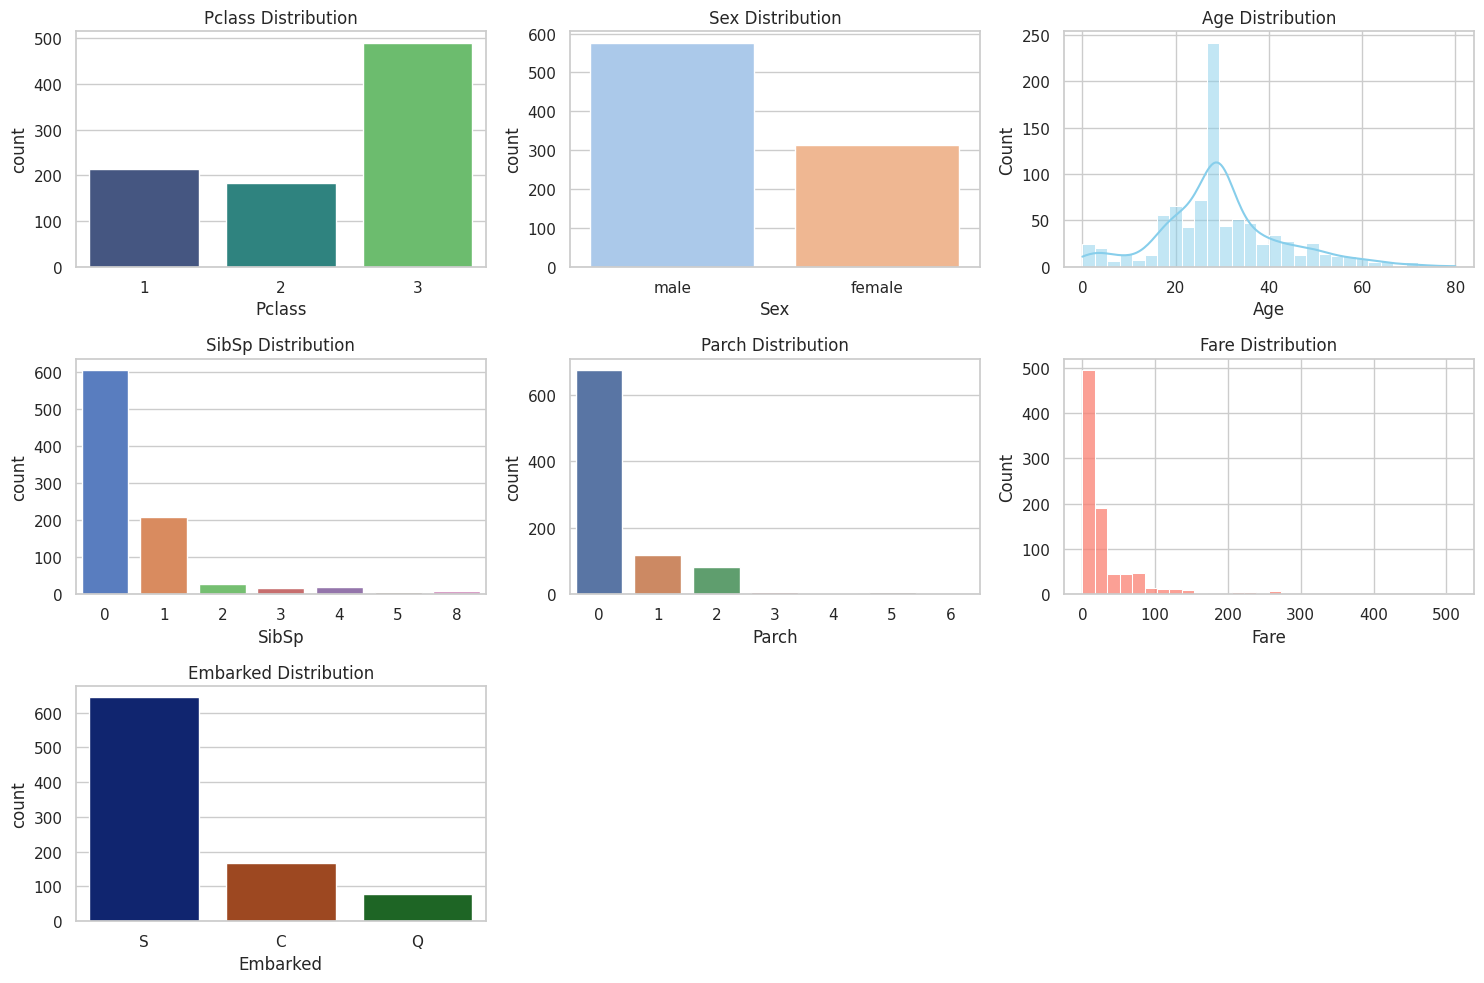

In [ ]:
data_for_plotting = df.select(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']).toPandas()

# Set the style for Seaborn
sns.set(style="whitegrid")

# Plotting the distribution using Seaborn
plt.figure(figsize=(15, 10))

# Pclass distribution
plt.subplot(3, 3, 1)
sns.countplot(x='Pclass', data=data_for_plotting, palette='viridis')
plt.title('Pclass Distribution')

# Sex distribution
plt.subplot(3, 3, 2)
sns.countplot(x='Sex', data=data_for_plotting, palette='pastel')
plt.title('Sex Distribution')

# Age distribution
plt.subplot(3, 3, 3)
sns.histplot(data_for_plotting['Age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution')

# SibSp distribution
plt.subplot(3, 3, 4)
sns.countplot(x='SibSp', data=data_for_plotting, palette='muted')
plt.title('SibSp Distribution')

# Parch distribution
plt.subplot(3, 3, 5)
sns.countplot(x='Parch', data=data_for_plotting, palette='deep')
plt.title('Parch Distribution')

# Fare distribution
plt.subplot(3, 3, 6)
sns.histplot(data_for_plotting['Fare'], bins=30, color='salmon')
plt.title('Fare Distribution')

# Embarked distribution
plt.subplot(3, 3, 7)
sns.countplot(x='Embarked', data=data_for_plotting, palette='dark')
plt.title('Embarked Distribution')

plt.tight_layout()
plt.show()

## Creation of dummy variables

To encode the categorical variables to numerical data, we create the dummy columns both for encoding and for data augmentation

In [ ]:
gender = df.select("Sex").distinct().rdd.flatMap(lambda x: x).collect()
embarked = df.select("Embarked").distinct().rdd.flatMap(lambda x: x).collect()
gender_expr = [F.when(F.col("Sex") == sex, 1).otherwise(0).alias("Gender_" + sex) for sex in gender]
embarked_expr = [F.when(F.col("Embarked") == port_name, 1).otherwise(0).alias("Port_" + port_name) for port_name in embarked]
df = df.select("age","Survived","Pclass","SibSp","Parch","Fare", *gender_expr+embarked_expr)
df

age,Survived,Pclass,SibSp,Parch,Fare,Gender_female,Gender_male,Port_Q,Port_C,Port_S
22,0,3,1,0,7.25,0,1,0,0,1
38,1,1,1,0,71.2833,1,0,0,1,0
26,1,3,0,0,7.925,1,0,0,0,1
35,1,1,1,0,53.1,1,0,0,0,1
35,0,3,0,0,8.05,0,1,0,0,1
29,0,3,0,0,8.4583,0,1,1,0,0
54,0,1,0,0,51.8625,0,1,0,0,1
2,0,3,3,1,21.075,0,1,0,0,1
27,1,3,0,2,11.1333,1,0,0,0,1
14,1,2,1,0,30.0708,1,0,0,1,0


## Correlation

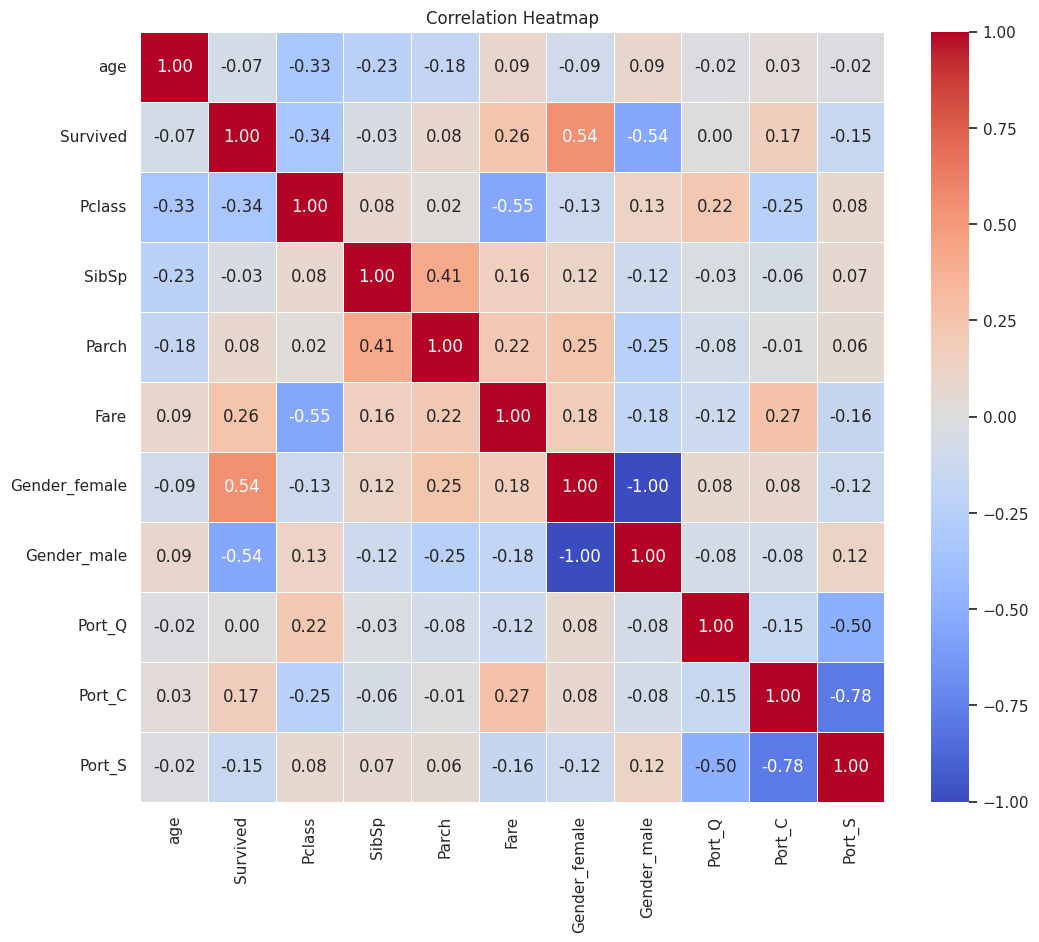

In [ ]:
# Obtain a matrix of correlation coefficients

correlation_matrix = df.toPandas().corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
df = df.drop('age')
df

Survived,Pclass,SibSp,Parch,Fare,Gender_female,Gender_male,Port_Q,Port_C,Port_S
0,3,1,0,7.25,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0
1,3,0,0,7.925,1,0,0,0,1
1,1,1,0,53.1,1,0,0,0,1
0,3,0,0,8.05,0,1,0,0,1
0,3,0,0,8.4583,0,1,1,0,0
0,1,0,0,51.8625,0,1,0,0,1
0,3,3,1,21.075,0,1,0,0,1
1,3,0,2,11.1333,1,0,0,0,1
1,2,1,0,30.0708,1,0,0,1,0


##Descriptive Statistics

In [ ]:
survival_rates = df.groupBy("Gender_female", "Gender_male").agg(
    round((sum("Survived") / count("*")), 2).alias("SurvivalRate")
)

survival_rates.show()

+-------------+-----------+------------+
|Gender_female|Gender_male|SurvivalRate|
+-------------+-----------+------------+
|            1|          0|        0.74|
|            0|          1|        0.19|
+-------------+-----------+------------+



See the impact of Embarked on survival

In [ ]:
# Calculate survival rate
survival_rates = df.groupBy("Port_Q", "Port_C", "Port_S").agg(
    round((sum("Survived") / count("*")), 2).alias("SurvivalRate")
)

survival_rates.show()

+------+------+------+------------+
|Port_Q|Port_C|Port_S|SurvivalRate|
+------+------+------+------------+
|     1|     0|     0|        0.39|
|     0|     1|     0|        0.55|
|     0|     0|     1|        0.34|
+------+------+------+------------+



See the impact of SibSp on survival

In [ ]:
survival_rates = df.groupBy("SibSp").agg(
    round((sum("Survived") / count("*")), 2).alias("SurvivalRate")
).orderBy("SibSp")

survival_rates.show()

+-----+------------+
|SibSp|SurvivalRate|
+-----+------------+
|    0|        0.34|
|    1|        0.54|
|    2|        0.46|
|    3|        0.25|
|    4|        0.17|
|    5|         0.0|
|    8|         0.0|
+-----+------------+



See the impact of Parch on survival

In [ ]:
survival_rates = df.groupBy("Parch").agg(
    round((sum("Survived") / count("*")), 2).alias("SurvivalRate")
).orderBy("Parch")
survival_rates.show()

+-----+------------+
|Parch|SurvivalRate|
+-----+------------+
|    0|        0.34|
|    1|        0.55|
|    2|         0.5|
|    3|         0.6|
|    4|         0.0|
|    5|         0.2|
|    6|         0.0|
+-----+------------+



 So i gusse the following feuture have a relation with "Survival"

 |-- Pclass:  Ticket class   
 |-- Sex: Sex of passenger    
 |-- SibSp: siblings / spouses aboard the Titanic   
 |-- Parch: parents / children aboard the Titanic   
 |-- Fare:  Passenger fare  
 |-- Embarked: Port of Embarkation

# Data preprocessing

In [ ]:
#Split train, test dataset
train, test = df.randomSplit([0.7, 0.3])

In [ ]:
col_to_train = train.toPandas().columns.tolist()[1:]
col_to_train

['Pclass',
 'SibSp',
 'Parch',
 'Fare',
 'Gender_female',
 'Gender_male',
 'Port_Q',
 'Port_C',
 'Port_S']

Use a VectorAssembler to put features into a feature vector column:

In [ ]:


# 定义特征列，排除目标列
feature_cols = [col for col in col_to_train if col != 'Survived']

# 创建 VectorAssembler，只包括特征列
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# 将训练数据和测试数据转换为特征向量
train_vec = assembler.transform(train)
test_vec = assembler.transform(test)

# 展示转换后的数据
train_vec.show(2, truncate=False)


+--------+------+-----+-----+----+-------------+-----------+------+------+------+-------------------------+
|Survived|Pclass|SibSp|Parch|Fare|Gender_female|Gender_male|Port_Q|Port_C|Port_S|features                 |
+--------+------+-----+-----+----+-------------+-----------+------+------+------+-------------------------+
|0       |1     |0    |0    |0.0 |0            |1          |0     |0     |1     |(9,[0,5,8],[1.0,1.0,1.0])|
|0       |1     |0    |0    |0.0 |0            |1          |0     |0     |1     |(9,[0,5,8],[1.0,1.0,1.0])|
+--------+------+-----+-----+----+-------------+-----------+------+------+------+-------------------------+
only showing top 2 rows



##Standardization

In [ ]:
# Initializing the StandardScaler
standard_scaler = StandardScaler(inputCol = 'features', outputCol="features_scaled")
train_model = standard_scaler.fit(train_vec)

train_scaled = train_model.transform(train_vec)
train_scaled.show(5, truncate=False)

+--------+------+-----+-----+----+-------------+-----------+------+------+------+-------------------------------+------------------------------------------------------------------------------------------+
|Survived|Pclass|SibSp|Parch|Fare|Gender_female|Gender_male|Port_Q|Port_C|Port_S|features                       |features_scaled                                                                           |
+--------+------+-----+-----+----+-------------+-----------+------+------+------+-------------------------------+------------------------------------------------------------------------------------------+
|0       |1     |0    |0    |0.0 |0            |1          |0     |0     |1     |(9,[0,5,8],[1.0,1.0,1.0])      |(9,[0,5,8],[1.199095249232597,2.0930467375456594,2.222026806733777])                      |
|0       |1     |0    |0    |0.0 |0            |1          |0     |0     |1     |(9,[0,5,8],[1.0,1.0,1.0])      |(9,[0,5,8],[1.199095249232597,2.0930467375456594,2.222026806733777]

In [ ]:
#With test set, we don't need to fit, we re-use the model already created by train set
test_scaled = train_model.transform(test_vec)
test_scaled.show(5, truncate=False)

+--------+------+-----+-----+-------+-------------+-----------+------+------+------+-----------------------------------+-----------------------------------------------------------------------------------------+
|Survived|Pclass|SibSp|Parch|Fare   |Gender_female|Gender_male|Port_Q|Port_C|Port_S|features                           |features_scaled                                                                          |
+--------+------+-----+-----+-------+-------------+-----------+------+------+------+-----------------------------------+-----------------------------------------------------------------------------------------+
|0       |1     |0    |0    |0.0    |0            |1          |0     |0     |1     |(9,[0,5,8],[1.0,1.0,1.0])          |(9,[0,5,8],[1.199095249232597,2.0930467375456594,2.222026806733777])                     |
|0       |1     |0    |0    |25.5875|0            |1          |0     |0     |1     |(9,[0,3,5,8],[1.0,25.5875,1.0,1.0])|(9,[0,3,5,8],[1.199095249232597,0.51

#Building Classification Model

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

## Logistic Regression

In [ ]:
classifier_1 = LogisticRegression(featuresCol='features_scaled', labelCol='Survived')
# Fitting the model to the data
model = classifier_1.fit(train_scaled)

# Making predictions
predictions = model.transform(test_scaled)

# Evaluate the model using BinaryClassificationEvaluator
accuracy_evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedPrecision')
precision = evaluator.evaluate(predictions)

evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedRecall')
recall = evaluator.evaluate(predictions)

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8077984817115254
Precision: 0.7868224123991876
Recall: 0.7884615384615385


## Random Forest

In [ ]:
# Initializing Logistic Regression as a classifier
classifier_2 = RandomForestClassifier(featuresCol='features_scaled', labelCol='Survived', numTrees=200)

# Fitting the model to the data
model = classifier_2.fit(train_scaled)

# Making predictions
predictions = model.transform(test_scaled)

# Evaluate the model using BinaryClassificationEvaluator
accuracy_evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedPrecision')
precision = evaluator.evaluate(predictions)

evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedRecall')
recall = evaluator.evaluate(predictions)

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8519355041094174
Precision: 0.7922956824596169
Recall: 0.7923076923076924


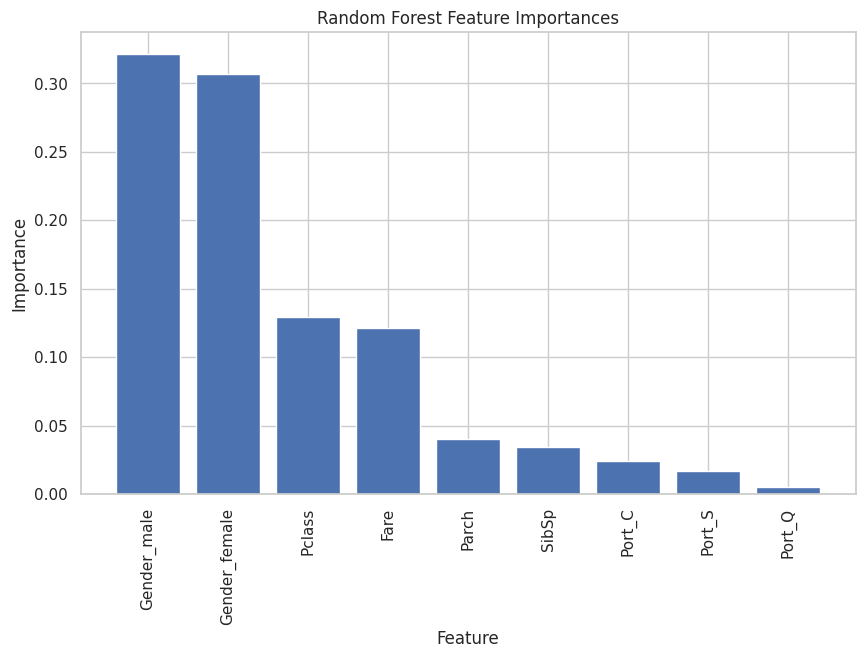

In [ ]:
feature_importances = model.featureImportances.toArray()

# Get the names of the features
feature_names = df.columns[1:]

# # Sort feature importances in descending order
indices = feature_importances.argsort()[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.show()

## Gradient-Boosted Trees (GBT)

In [ ]:
classifier_3 = GBTClassifier(featuresCol='features_scaled', labelCol='Survived', maxDepth=4, maxIter=20)
# Fitting the pipeline to the data
model = classifier_3.fit(train_scaled)

# Making predictions
predictions = model.transform(test_scaled)

# Evaluate the model using BinaryClassificationEvaluator
accuracy_evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedPrecision')
precision = evaluator.evaluate(predictions)

evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedRecall')
recall = evaluator.evaluate(predictions)

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8389171215258171
Precision: 0.7823265491904545
Recall: 0.7846153846153846


at last we choose randomforest as our model

In [ ]:
# Initializing Logistic Regression as a classifier
classifier_2 = RandomForestClassifier(featuresCol='features_scaled', labelCol='Survived', numTrees=200)

# Fitting the model to the data
model = classifier_2.fit(train_scaled)

# Making predictions
predictions = model.transform(test_scaled)

# Evaluate the model using BinaryClassificationEvaluator
accuracy_evaluator = BinaryClassificationEvaluator(labelCol='Survived', metricName='areaUnderROC')
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedPrecision')
precision = evaluator.evaluate(predictions)

evaluator = MulticlassClassificationEvaluator(labelCol='Survived', metricName='weightedRecall')
recall = evaluator.evaluate(predictions)

# Print precision and recall
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8519355041094174
Precision: 0.7922956824596169
Recall: 0.7923076923076924


In [ ]:
df_test = spark.read.csv('test.csv',header = 'True',inferSchema='True')
df_test.limit(3).toPandas()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,None,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,None,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,None,Q


In [ ]:
# Count the number of missing values in each column
missing_counts = df_test.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_test.columns]).toPandas()
missing_counts

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,86,0,0,0,1,327,0


In [ ]:
df_test = df_test.drop('Cabin', 'Name', 'Ticket','age')

In [ ]:
# Count the number of missing values in each column
missing_counts = df_test.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_test.columns]).toPandas()
missing_counts

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,0,0,0,0,1,0


In [ ]:
mean_value_Fare = df_test.select(mean(col('Fare'))).collect()[0][0]
mean_value_Fare

35.6271884892086

In [ ]:
df_test = df_test.fillna(value = mean_value, subset = ["Fare"])

In [ ]:
df_test

PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked
892,3,male,0,0,7.8292,Q
893,3,female,1,0,7.0,S
894,2,male,0,0,9.6875,Q
895,3,male,0,0,8.6625,S
896,3,female,1,1,12.2875,S
897,3,male,0,0,9.225,S
898,3,female,0,0,7.6292,Q
899,2,male,1,1,29.0,S
900,3,female,0,0,7.2292,C
901,3,male,2,0,24.15,S


In [ ]:
gender = df_test.select("Sex").distinct().rdd.flatMap(lambda x: x).collect()
embarked = df_test.select("Embarked").distinct().rdd.flatMap(lambda x: x).collect()
gender_expr = [F.when(F.col("Sex") == sex, 1).otherwise(0).alias("Gender_" + sex) for sex in gender]
embarked_expr = [F.when(F.col("Embarked") == port_name, 1).otherwise(0).alias("Port_" + port_name) for port_name in embarked]
df_test = df_test.select("PassengerId","Pclass","SibSp","Parch","Fare", *gender_expr+embarked_expr)
df_test

PassengerId,Pclass,SibSp,Parch,Fare,Gender_female,Gender_male,Port_Q,Port_C,Port_S
892,3,0,0,7.8292,0,1,1,0,0
893,3,1,0,7.0,1,0,0,0,1
894,2,0,0,9.6875,0,1,1,0,0
895,3,0,0,8.6625,0,1,0,0,1
896,3,1,1,12.2875,1,0,0,0,1
897,3,0,0,9.225,0,1,0,0,1
898,3,0,0,7.6292,1,0,1,0,0
899,2,1,1,29.0,0,1,0,0,1
900,3,0,0,7.2292,1,0,0,1,0
901,3,2,0,24.15,0,1,0,0,1


In [ ]:
# 定义特征列，排除目标列
feature_cols = [col for col in col_to_train if col != 'Survived']
feature_cols

['Pclass',
 'SibSp',
 'Parch',
 'Fare',
 'Gender_female',
 'Gender_male',
 'Port_Q',
 'Port_C',
 'Port_S']

In [ ]:


# 创建 VectorAssembler，只包括特征列
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# 将训练数据和测试数据转换为特征向量
df_test_vec = assembler.transform(df_test)


# 展示转换后的数据
df_test_vec.show(2, truncate=False)

+-----------+------+-----+-----+------+-------------+-----------+------+------+------+-------------------------------------+
|PassengerId|Pclass|SibSp|Parch|Fare  |Gender_female|Gender_male|Port_Q|Port_C|Port_S|features                             |
+-----------+------+-----+-----+------+-------------+-----------+------+------+------+-------------------------------------+
|892        |3     |0    |0    |7.8292|0            |1          |1     |0     |0     |(9,[0,3,5,6],[3.0,7.8292,1.0,1.0])   |
|893        |3     |1    |0    |7.0   |1            |0          |0     |0     |1     |[3.0,1.0,0.0,7.0,1.0,0.0,0.0,0.0,1.0]|
+-----------+------+-----+-----+------+-------------+-----------+------+------+------+-------------------------------------+
only showing top 2 rows



In [ ]:
# Initializing the StandardScaler
standard_scaler = StandardScaler(inputCol = 'features', outputCol="features_scaled")
train_model = standard_scaler.fit(df_test_vec)

df_test_scaled = train_model.transform(df_test_vec)
df_test_scaled.show(5, truncate=False)

+-----------+------+-----+-----+-------+-------------+-----------+------+------+------+-----------------------------------------+----------------------------------------------------------------------------------------------------------------------------+
|PassengerId|Pclass|SibSp|Parch|Fare   |Gender_female|Gender_male|Port_Q|Port_C|Port_S|features                                 |features_scaled                                                                                                             |
+-----------+------+-----+-----+-------+-------------+-----------+------+------+------+-----------------------------------------+----------------------------------------------------------------------------------------------------------------------------+
|892        |3     |0    |0    |7.8292 |0            |1          |1     |0     |0     |(9,[0,3,5,6],[3.0,7.8292,1.0,1.0])       |(9,[0,3,5,6],[3.563632903997743,0.14020457699459818,2.076316504188104,3.1915803504282687])                

In [ ]:
# Making predictions
df_predictions = model.transform(df_test_scaled)

In [ ]:
df_predictions

PassengerId,Pclass,SibSp,Parch,Fare,Gender_female,Gender_male,Port_Q,Port_C,Port_S,features,features_scaled,rawPrediction,probability,prediction
892,3,0,0,7.8292,0,1,1,0,0,"(9,[0,3,5,6],[3.0...","(9,[0,3,5,6],[3.5...",[175.857034369608...,[0.87928517184804...,0.0
893,3,1,0,7.0,1,0,0,0,1,"[3.0,1.0,0.0,7.0,...",[3.56363290399774...,[99.9104017936101...,[0.49955200896805...,1.0
894,2,0,0,9.6875,0,1,1,0,0,"(9,[0,3,5,6],[2.0...","(9,[0,3,5,6],[2.3...",[171.078030422479...,[0.85539015211239...,0.0
895,3,0,0,8.6625,0,1,0,0,1,"(9,[0,3,5,8],[3.0...","(9,[0,3,5,8],[3.5...",[175.008807252198...,[0.87504403626099...,0.0
896,3,1,1,12.2875,1,0,0,0,1,"[3.0,1.0,1.0,12.2...",[3.56363290399774...,[94.8511818401052...,[0.47425590920052...,1.0
897,3,0,0,9.225,0,1,0,0,1,"(9,[0,3,5,8],[3.0...","(9,[0,3,5,8],[3.5...",[175.311638498563...,[0.87655819249281...,0.0
898,3,0,0,7.6292,1,0,1,0,0,"(9,[0,3,4,6],[3.0...","(9,[0,3,4,6],[3.5...",[75.9519996852099...,[0.37975999842604...,1.0
899,2,1,1,29.0,0,1,0,0,1,"[2.0,1.0,1.0,29.0...",[2.37575526933182...,[146.230124863529...,[0.73115062431764...,0.0
900,3,0,0,7.2292,1,0,0,1,0,"(9,[0,3,4,7],[3.0...","(9,[0,3,4,7],[3.5...",[48.3387644271190...,[0.24169382213559...,1.0
901,3,2,0,24.15,0,1,0,0,1,"[3.0,2.0,0.0,24.1...",[3.56363290399774...,[167.736603049286...,[0.83868301524643...,0.0


In [ ]:
df_result = df_predictions[['PassengerId', 'prediction']]
df_result

PassengerId,prediction
892,0.0
893,1.0
894,0.0
895,0.0
896,1.0
897,0.0
898,1.0
899,0.0
900,1.0
901,0.0


In [ ]:
df_result = df_result.withColumnRenamed("prediction", "Survived")

In [ ]:
df_result

PassengerId,Survived
892,0.0
893,1.0
894,0.0
895,0.0
896,1.0
897,0.0
898,1.0
899,0.0
900,1.0
901,0.0


In [ ]:
df_result.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: double (nullable = false)



In [ ]:
new_df = df_result.withColumn("Survived", col("Survived").cast("int"))

# 显示新的 DataFrame 结构
new_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)



In [ ]:
output_path = 'output.csv'
new_df.write.csv(output_path, header=True, mode="overwrite")

# 停止 SparkSession
spark.stop()